In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
import itertools
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [2]:
model = nn.Sequential(
    
    nn.Linear(16, 20),
    nn.ReLU(),
    
    nn.Linear(20, 25),
    nn.ReLU(),
    
    nn.Linear(25, 30),
    nn.ReLU(),
    
    nn.Linear(30, 35),
    nn.ReLU(),
    
    nn.Linear(35, 30),
    nn.ReLU(),
    
    nn.Linear(30, 25),
    nn.ReLU(),
    
    nn.Linear(25, 20),
    nn.ReLU(),
    
    nn.Linear(20, 15),
    nn.ReLU(),
    
    nn.Linear(15, 10),
    nn.ReLU(),
    
    nn.Linear(10, 4),
)

In [3]:
actions_walker2d= np.load("actions_TRPO_walker2d_6.npy")[:4000]

In [4]:
actions_walker2d = torch.tensor(actions_walker2d, dtype=torch.float)
print("actions_walker2d.shape",actions_walker2d.shape)

actions_walker2d.shape torch.Size([4000, 500, 4])


In [5]:
def pre_processing (array, n=3):
    ep, t, _= array.shape
    output = torch.zeros ((ep*(t-n), 4*(n+1)))
    index=0
    indices = []
    for i in range (ep):
        for j in range (t-n):
            output[index] = array[i, j:j+n+1].view(-1)
            index+=1
    for i in range (output.shape[0]):
        if (output[i] == -1*torch.ones(4*(n+1))).any():
            indices.append(i)
    cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
    return cleaned_data
new_data  = pre_processing(actions_walker2d, 4)
print("new_data.shape",new_data.shape)

new_data.shape torch.Size([1953681, 20])


In [6]:
training_set = new_data[:1000000]
testing_set = new_data[1000000:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([1000000, 20])
testing_set torch.Size([953681, 20])


# traning

In [7]:
losses = []
n_itrations=500
batch_size=256
# torch.load("Walker2d_model_n=4")
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
for itr in range (n_itrations):
    if itr%50 ==0:
        torch.save(model, "Walker2d_model_n=4")        
    total_loss = 0
    total_acc = []
    for b in range (0, training_set.shape[0], batch_size):
        y = torch.tensor(training_set[b:b+batch_size, 16:], dtype=torch.float)
        y_pred = model(training_set[b:b+batch_size, 0:16])
#         print("y_pred", y_pred)
        loss = loss_function(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(total_loss)
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr, total_loss))
#     print("[EPOCH]: %i, [LOSS]: %.6f ,[acc]: %.3f" % (itr, total_loss, np.mean(np.array(total_acc))))

/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


[EPOCH]: 0, [LOSS]: 1022.990475
[EPOCH]: 1, [LOSS]: 575.388665
[EPOCH]: 2, [LOSS]: 492.690763
[EPOCH]: 3, [LOSS]: 461.555200
[EPOCH]: 4, [LOSS]: 444.362676
[EPOCH]: 5, [LOSS]: 430.427822
[EPOCH]: 6, [LOSS]: 420.441273
[EPOCH]: 7, [LOSS]: 412.654688
[EPOCH]: 8, [LOSS]: 405.971576
[EPOCH]: 9, [LOSS]: 400.331632
[EPOCH]: 10, [LOSS]: 395.686804
[EPOCH]: 11, [LOSS]: 391.502103
[EPOCH]: 12, [LOSS]: 387.809969
[EPOCH]: 13, [LOSS]: 384.548245
[EPOCH]: 14, [LOSS]: 381.636212
[EPOCH]: 15, [LOSS]: 378.667993
[EPOCH]: 16, [LOSS]: 375.948403
[EPOCH]: 17, [LOSS]: 373.531834
[EPOCH]: 18, [LOSS]: 371.258814
[EPOCH]: 19, [LOSS]: 369.242371
[EPOCH]: 20, [LOSS]: 367.459312
[EPOCH]: 21, [LOSS]: 365.774948
[EPOCH]: 22, [LOSS]: 364.157812
[EPOCH]: 23, [LOSS]: 362.580028
[EPOCH]: 24, [LOSS]: 361.097160
[EPOCH]: 25, [LOSS]: 359.771899
[EPOCH]: 26, [LOSS]: 358.508335
[EPOCH]: 27, [LOSS]: 357.366290
[EPOCH]: 28, [LOSS]: 356.309151
[EPOCH]: 29, [LOSS]: 355.257080
[EPOCH]: 30, [LOSS]: 354.235088
[EPOCH]: 31, [LOS

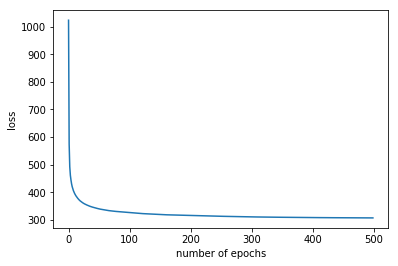

In [8]:
torch.save(model, "Walker2d_model_n=4")
plt.plot(losses)
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

# test

In [9]:
y = torch.tensor(testing_set[203, 16:], dtype=torch.float)
y_pred = model(testing_set[203, :16])
print("y",y)
print("y_pred",y_pred)
print("loss",loss_function(y_pred, y).item())

y tensor([0.1229, 2.2998, 1.1321, 0.1326])
y_pred tensor([ 0.0451,  2.3398,  0.8126, -0.1243], grad_fn=<AddBackward0>)
loss 0.04392902925610542


/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [52]:
def find_all_combination (n):
    combination = torch.zeros((n*n,4*n), dtype=torch.float)
    return torch.tensor([list(i) for i in itertools.product([0.0, 1.0], repeat=4*n)])

# bca

In [29]:
m = torch.load("Walker2d_model_n=2")
m[:8]

Sequential(
  (0): Linear(in_features=8, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=30, bias=True)
  (7): ReLU()
)

In [12]:
def prepare_inputs (n): 
    m = -np.ones((1, 4*n))
    o2 = -0.5*np.ones((1, 4*n ))
    z = np.zeros((1, 4*n ))
    o1 = 0.5*np.ones((1, 4*n ))
    o = np.ones((1, 4*n ))
    zom = torch.tensor(np.concatenate((m, o2, z, o1, o), 0), dtype=torch.float)
    return zom

In [53]:
# zom = prepare_inputs (4)
zom = find_all_combination (2)
zom

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [54]:
vectors = m[:8](zom).detach().numpy()
vectors.shape

(256, 30)

In [55]:
pca = PCA(n_components=2, svd_solver='full' ).fit_transform(vectors)
pca.shape

(256, 2)

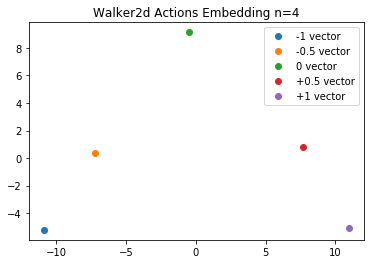

In [16]:
# for i in range (pca.shape[0]):
#     plt.plot(list(pca[i])[0], list(pca[i])[1] ,"o", label="{}".format(i))
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="-1 vector")
plt.plot(list(pca[1])[0], list(pca[1])[1] ,"o", label="-0.5 vector")
plt.plot(list(pca[2])[0], list(pca[2])[1] ,"o", label="0 vector")
plt.plot(list(pca[3])[0], list(pca[3])[1] ,"o", label="+0.5 vector")
plt.plot(list(pca[4])[0], list(pca[4])[1] ,"o", label="+1 vector")
plt.title("Walker2d Actions Embedding n=4")
plt.legend()
# plt.savefig("fig/Walker2d_n=4", dpi=600)

# Kmeans

Text(0.5,1,'Unevenly Sized Blobs')

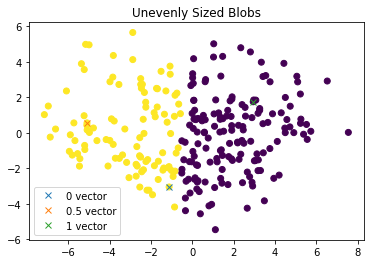

In [60]:
kmean = KMeans(n_clusters=2, random_state=0).fit_predict(pca)
plt.scatter(pca[:, 0], pca[:, 1], c=kmean)
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"x", label="0 vector")
plt.plot(list(pca[200])[0], list(pca[200])[1] ,"x", label="0.5 vector")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"x", label="1 vector")
plt.legend()
plt.title("Unevenly Sized Blobs")